In [2]:
import transformers
print(transformers.__version__)

4.45.2


In [3]:
!pip install pandas requests tqdm --quiet

import pandas as pd
import requests
import gzip
import json
from tqdm import tqdm

In [4]:
DATASET_URLS = {
    "Electronics": "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz",
    "Beauty": "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Beauty_5.json.gz",
    "Toys": "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz",
    "Sports": "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Sports_and_Outdoors_5.json.gz",
    "Home_Kitchen": "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz"
}

In [5]:
def load_category(category_name, max_reviews=10000):

    url = DATASET_URLS[category_name]
    print(f"\n📦 Loading {category_name}...")

    response = requests.get(url, stream=True)
    response.raise_for_status()

    reviews = []
    count = 0

    with gzip.GzipFile(fileobj=response.raw) as f:
        for line in tqdm(f):
            review = json.loads(line)

            reviews.append({
                "review": review.get("reviewText", ""),
                "rating": review.get("overall", 0),
                "summary": review.get("summary", ""),
                "verified": review.get("verified", False),
                "time": review.get("unixReviewTime", 0),
                "category": category_name
            })

            count += 1
            if count >= max_reviews:
                break

    df = pd.DataFrame(reviews)
    print(f"✅ Loaded {len(df)} rows from {category_name}")
    return df

In [6]:
categories = ["Electronics", "Beauty", "Toys", "Sports", "Home_Kitchen"]

all_data = []

for cat in categories:
    df_cat = load_category(cat, max_reviews=10000)
    all_data.append(df_cat)

df = pd.concat(all_data, ignore_index=True)

print("\n📊 Final Dataset Shape:", df.shape)
print("\nReviews per Category:")
print(df["category"].value_counts())


📦 Loading Electronics...


9999it [00:00, 16339.48it/s]


✅ Loaded 10000 rows from Electronics

📦 Loading Beauty...


9999it [00:00, 24650.80it/s]


✅ Loaded 10000 rows from Beauty

📦 Loading Toys...


9999it [00:00, 21477.60it/s]


✅ Loaded 10000 rows from Toys

📦 Loading Sports...


9999it [00:00, 20961.52it/s]


✅ Loaded 10000 rows from Sports

📦 Loading Home_Kitchen...


9999it [00:00, 25355.26it/s]


✅ Loaded 10000 rows from Home_Kitchen

📊 Final Dataset Shape: (50000, 6)

Reviews per Category:
category
Electronics     10000
Beauty          10000
Toys            10000
Sports          10000
Home_Kitchen    10000
Name: count, dtype: int64


In [7]:
df.to_csv("amazon_reviews_50k.csv", index=False)
print("💾 Saved as amazon_reviews_50k.csv")

💾 Saved as amazon_reviews_50k.csv


Exploratory Data Analysis

In [8]:
df = pd.read_csv("amazon_reviews_50k.csv")
print("Shape:", df.shape)
df.head()

Shape: (50000, 6)


,review,rating,summary,verified,time,category
0,We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,False,1370131200,Electronics
1,"I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,False,1290643200,Electronics
2,"Well, what can I say. I've had this unit in m...",3.0,1st impression,False,1283990400,Electronics
3,"Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",False,1290556800,Electronics
4,I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",False,1317254400,Electronics


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   review    49972 non-null  object 
 1   rating    50000 non-null  float64
 2   summary   50000 non-null  object 
 3   verified  50000 non-null  bool   
 4   time      50000 non-null  int64  
 5   category  50000 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 2.0+ MB
None


In [10]:
df.isnull().sum()

,0
review,28
rating,0
summary,0
verified,0
time,0
category,0


In [11]:
df = df.dropna(subset=["review"])
df.reset_index(drop=True, inplace=True)

print("New shape:", df.shape)

New shape: (49972, 6)


In [12]:
df.duplicated(subset="review").sum()

np.int64(8)

In [13]:
df = df.drop_duplicates(subset="review")
df.reset_index(drop=True, inplace=True)
df.shape

(49964, 6)

Data Quality Insight:

Dataset is highly clean with negligible missing values.

Duplicate reviews represent less than 0.1% of data and were removed.

Final dataset remains sufficiently large (~49.9K samples), ensuring statistical reliability.

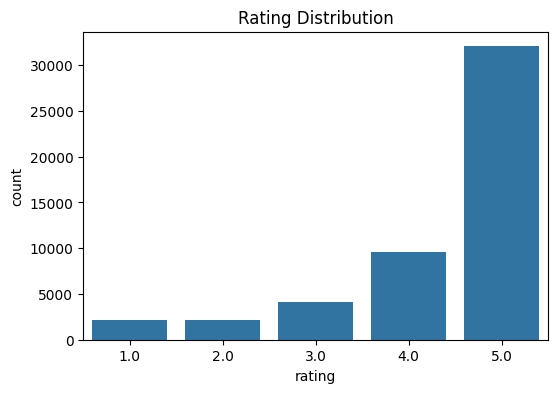

rating
1.0     2148
2.0     2104
3.0     4124
4.0     9532
5.0    32056
Name: count, dtype: int64


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=df)
plt.title("Rating Distribution")
plt.show()

print(df["rating"].value_counts().sort_index())

Class Imbalance Insight:

Strong positive skew (5-star reviews dominate ~64%).

Negative classes (1 & 2) form a small minority.

Accuracy alone would be misleading for model evaluation.

Macro-F1 score will be prioritized over raw accuracy.

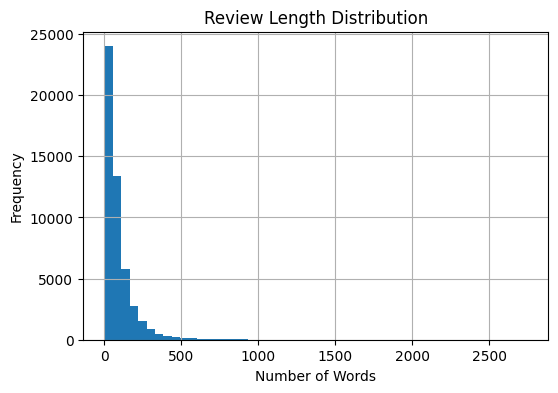

Average review length: 92.99061324153391


In [15]:
df["review_length"] = df["review"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,4))
df["review_length"].hist(bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

print("Average review length:", df["review_length"].mean())

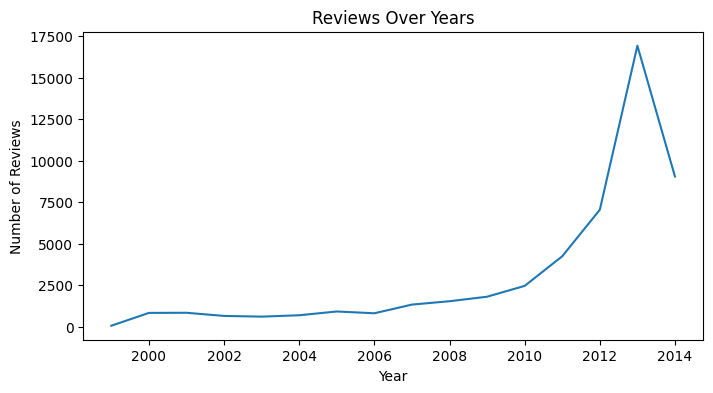

In [16]:
df["date"] = pd.to_datetime(df["time"], unit="s")
df["year"] = df["date"].dt.year

plt.figure(figsize=(8,4))
df["year"].value_counts().sort_index().plot(kind="line")
plt.title("Reviews Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.show()

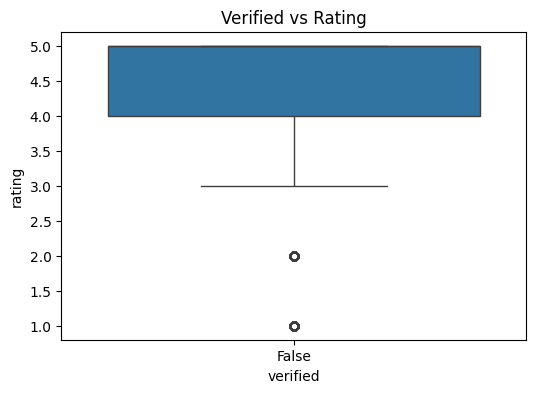

,rating
verified,
False,4.345849


In [17]:
plt.figure(figsize=(6,4))
sns.boxplot(x="verified", y="rating", data=df)
plt.title("Verified vs Rating")
plt.show()

df.groupby("verified")["rating"].mean()

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english", max_features=20)
X = vectorizer.fit_transform(df["review"])

print("Top words:", vectorizer.get_feature_names_out())

Top words: ['bought' 'does' 'don' 'easy' 'game' 'good' 'great' 'just' 'like' 'little'
 'love' 'price' 'product' 'really' 'skin' 'time' 'use' 'used' 'using' 've']


In [19]:
def rating_to_sentiment(r):
    if r <= 2:
        return "Negative"
    elif r == 3:
        return "Neutral"
    else:
        return "Positive"

df["sentiment"] = df["rating"].apply(rating_to_sentiment)

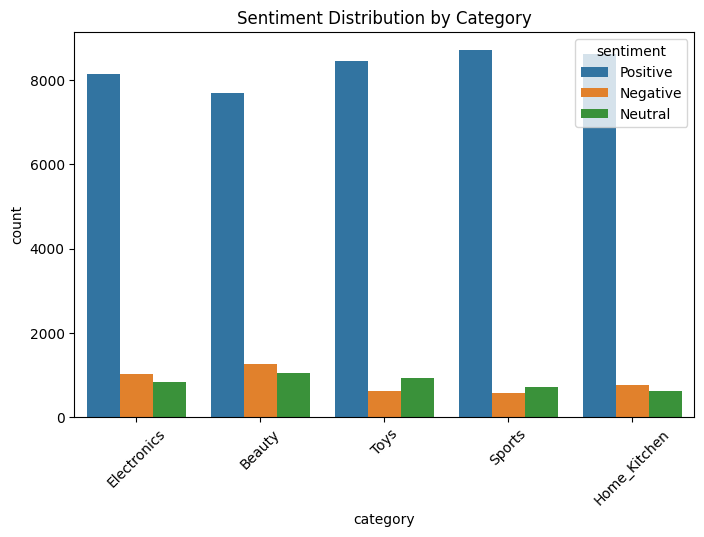

In [20]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="category", hue="sentiment")
plt.xticks(rotation=45)
plt.title("Sentiment Distribution by Category")
plt.show()

In [21]:
sentiment_ratio = (
    df.groupby("category")["sentiment"]
      .value_counts(normalize=True)
      .unstack()
)

print(sentiment_ratio)

sentiment     Negative   Neutral  Positive
category                                  
Beauty        0.125950  0.104242  0.769808
Electronics   0.102172  0.082258  0.815571
Home_Kitchen  0.076554  0.062444  0.861003
Sports        0.057958  0.071171  0.870871
Toys          0.062850  0.092574  0.844576


Insight:
Beauty category has the highest negative review ratio (~12.6%).

Sports and Home_Kitchen show highest positive sentiment (>86%).

Electronics maintains strong positive dominance but still shows notable dissatisfaction (~10%).

Beauty products are subjective → higher dissatisfaction risk.

In [22]:
df.groupby("category")["review_length"].mean().sort_values(ascending=False)

,review_length
category,
Electronics,112.311318
Toys,104.029424
Home_Kitchen,87.533574
Beauty,83.610744
Sports,77.467267


Insight:

Electronics receives the longest reviews, indicating complex product feedback.

Sports has shortest reviews, suggesting simpler purchase decisions.

Longer reviews correlate with technically complex categories.


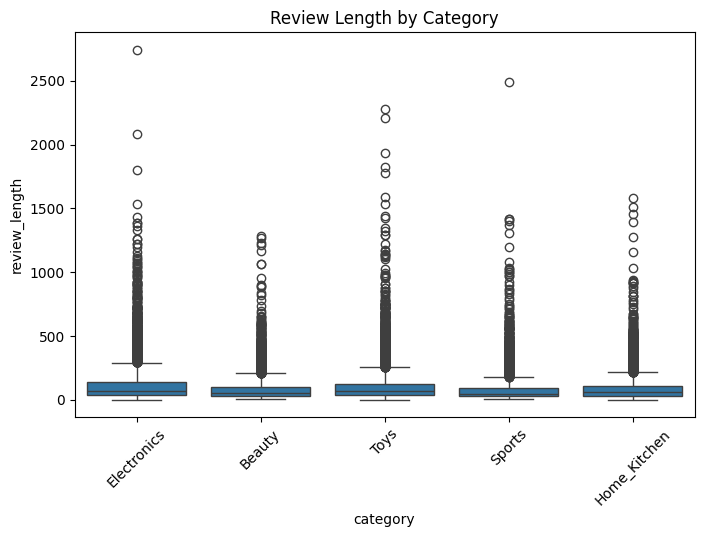

In [23]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="category", y="review_length")
plt.xticks(rotation=45)
plt.title("Review Length by Category")
plt.show()

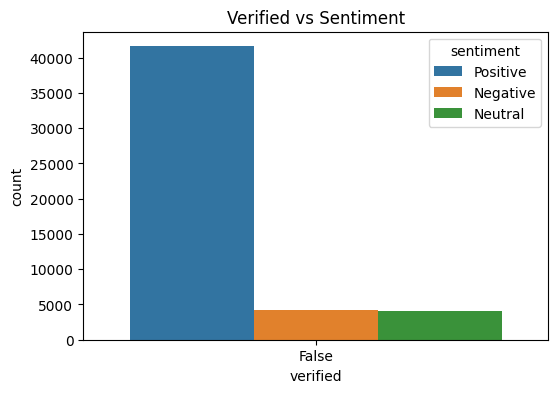

,rating
verified,
False,4.345849


In [24]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="verified", hue="sentiment")
plt.title("Verified vs Sentiment")
plt.show()

df.groupby("verified")["rating"].mean()

Majority of reviews are non-verified purchases.

This may introduce authenticity concerns.

Verified purchase modeling can be a future enhancement for trust-based filtering.

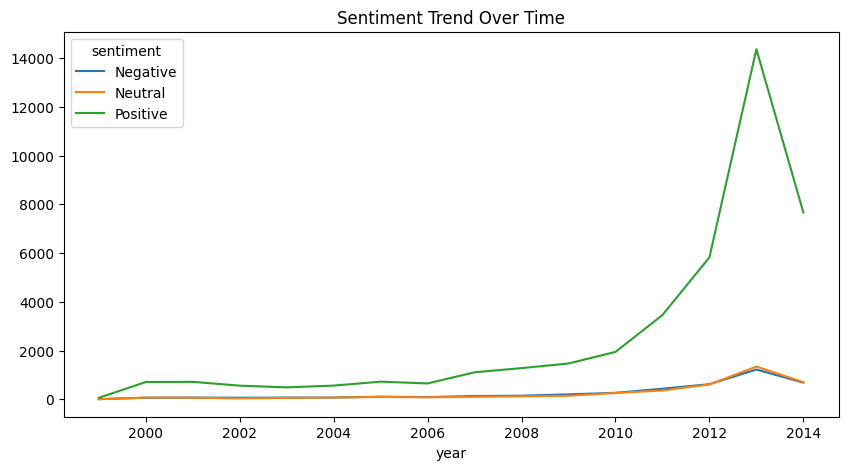

In [25]:
df["date"] = pd.to_datetime(df["time"], unit="s")
df["year"] = df["date"].dt.year

sentiment_year = (
    df.groupby(["year", "sentiment"])
      .size()
      .unstack()
)

sentiment_year.plot(figsize=(10,5))
plt.title("Sentiment Trend Over Time")
plt.show()

Insight:

Platform review activity significantly increased after 2010.

Positive sentiment dominates growth trend.

No drastic increase in negative sentiment over time.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

negative_df = df[df["sentiment"] == "Negative"]

vectorizer = CountVectorizer(stop_words="english", max_features=20)
X = vectorizer.fit_transform(negative_df["review"].fillna(""))

print("Top complaint words:")
print(vectorizer.get_feature_names_out())

Top complaint words:
['better' 'bought' 'buy' 'did' 'didn' 'does' 'don' 'good' 'got' 'hair'
 'just' 'like' 'product' 'really' 'skin' 'time' 'use' 'used' 'using'
 'work']


Insight:

Frequent complaint words include “didn”, “work”, “better”.

Beauty-related complaints include “hair” and “skin”.

Functional dissatisfaction appears to be primary driver of negative sentiment.

Text Preprocessing & Feature Engineering

In [27]:
!pip install nltk --quiet

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [28]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):

    text = str(text).lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)

    # Remove numbers
    text = re.sub(r"\d+", "", text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Tokenize
    tokens = text.split()

    # Remove stopwords
    tokens = [w for w in tokens if w not in stop_words]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    return " ".join(tokens)

In [29]:
df["clean_review"] = df["review"].apply(clean_text)

print("Sample cleaned text:\n")
print(df["clean_review"].iloc[0])

Sample cleaned text:

got gps husband otr road trucker impressed shipping time arrived day earlier expected within week use however started freezing could glitch unit worked great worked work great normal person well trucker option big truck route tell scale coming ect love bigger screen ease use ease putting address memory nothing really bad say unit exception freezing probably one million thats luck contacted seller within minute email received email back instruction exchange impressed way around


In [30]:
def rating_to_label(r):
    if r <= 2:
        return 0
    elif r == 3:
        return 1
    else:
        return 2

df["label"] = df["rating"].apply(rating_to_label)

In [31]:
from sklearn.model_selection import train_test_split

X = df["clean_review"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (39971,)
Test size: (9993,)


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.9
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF Shape:", X_train_tfidf.shape)

TF-IDF Shape: (39971, 50000)


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [34]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [35]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    print(f"\n===== {name} =====")
    print("Accuracy:", round(acc,4))
    print("Macro F1:", round(macro_f1,4))
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc, macro_f1


===== Logistic Regression =====
Accuracy: 0.7969
Macro F1: 0.5817

Classification Report:

              precision    recall  f1-score   support

           0       0.46      0.61      0.53       850
           1       0.26      0.42      0.32       825
           2       0.94      0.85      0.89      8318

    accuracy                           0.80      9993
   macro avg       0.56      0.63      0.58      9993
weighted avg       0.84      0.80      0.82      9993



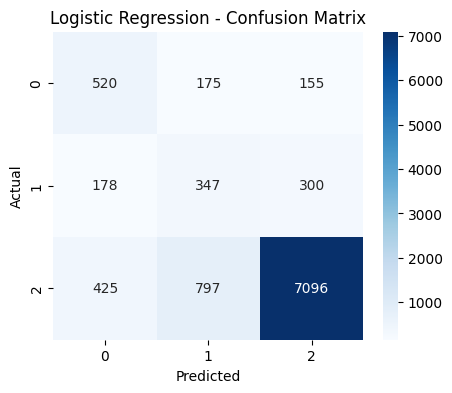

In [36]:
log_model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced"
)

log_model.fit(X_train_tfidf, y_train)

log_acc, log_f1 = evaluate_model(
    "Logistic Regression",
    log_model,
    X_test_tfidf,
    y_test
)


===== Linear SVM =====
Accuracy: 0.8508
Macro F1: 0.5794

Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.52      0.55       850
           1       0.31      0.22      0.26       825
           2       0.91      0.95      0.93      8318

    accuracy                           0.85      9993
   macro avg       0.60      0.56      0.58      9993
weighted avg       0.83      0.85      0.84      9993



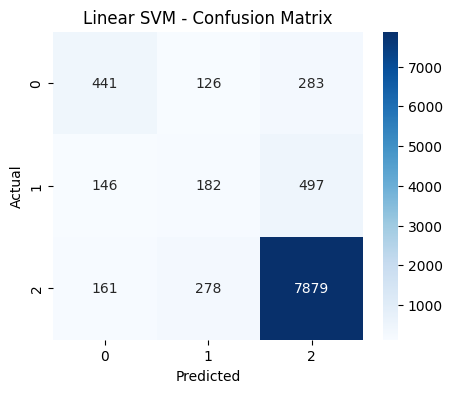

In [37]:
svm_model = LinearSVC(class_weight="balanced")

svm_model.fit(X_train_tfidf, y_train)

svm_acc, svm_f1 = evaluate_model(
    "Linear SVM",
    svm_model,
    X_test_tfidf,
    y_test
)


===== Naive Bayes =====
Accuracy: 0.8324
Macro F1: 0.3028

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       850
           1       0.00      0.00      0.00       825
           2       0.83      1.00      0.91      8318

    accuracy                           0.83      9993
   macro avg       0.28      0.33      0.30      9993
weighted avg       0.69      0.83      0.76      9993



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


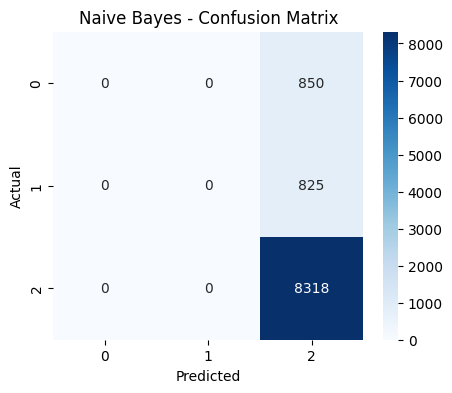

In [38]:
nb_model = MultinomialNB()

nb_model.fit(X_train_tfidf, y_train)

nb_acc, nb_f1 = evaluate_model(
    "Naive Bayes",
    nb_model,
    X_test_tfidf,
    y_test
)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [00:04:50] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



===== XGBoost =====
Accuracy: 0.852
Macro F1: 0.4614

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.22      0.34       850
           1       0.55      0.07      0.12       825
           2       0.86      0.99      0.92      8318

    accuracy                           0.85      9993
   macro avg       0.72      0.43      0.46      9993
weighted avg       0.82      0.85      0.81      9993



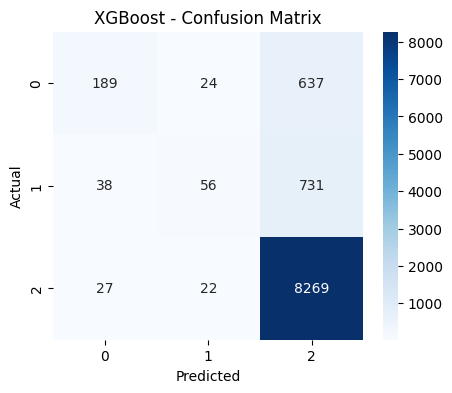

In [39]:
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    use_label_encoder=False,
    tree_method="hist"
)

xgb_model.fit(X_train_tfidf, y_train)

xgb_acc, xgb_f1 = evaluate_model(
    "XGBoost",
    xgb_model,
    X_test_tfidf,
    y_test
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.923997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 415452
[LightGBM] [Info] Number of data points in the train set: 39971, number of used features: 11901
[LightGBM] [Info] Start training from score -2.463791
[LightGBM] [Info] Start training from score -2.494535
[LightGBM] [Info] Start training from score -0.183498


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



===== LightGBM =====
Accuracy: 0.8591
Macro F1: 0.5251

Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.37      0.48       850
           1       0.42      0.10      0.17       825
           2       0.88      0.98      0.93      8318

    accuracy                           0.86      9993
   macro avg       0.66      0.49      0.53      9993
weighted avg       0.82      0.86      0.83      9993



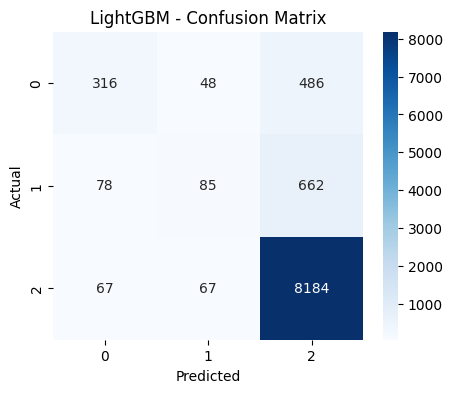

In [40]:
lgbm_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.07,
    num_leaves=50,
    objective="multiclass",
    n_jobs=-1
)

lgbm_model.fit(X_train_tfidf, y_train)

lgbm_acc, lgbm_f1 = evaluate_model(
    "LightGBM",
    lgbm_model,
    X_test_tfidf,
    y_test
)

In [41]:
results = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Linear SVM",
        "Naive Bayes",
        "XGBoost",
        "LightGBM"
    ],
    "Accuracy": [
        log_acc,
        svm_acc,
        nb_acc,
        xgb_acc,
        lgbm_acc
    ],
    "Macro F1": [
        log_f1,
        svm_f1,
        nb_f1,
        xgb_f1,
        lgbm_f1
    ]
})

results.sort_values(by="Macro F1", ascending=False)

,Model,Accuracy,Macro F1
0,Logistic Regression,0.796858,0.581711
1,Linear SVM,0.850796,0.579370
4,LightGBM,0.859101,0.525098
3,XGBoost,0.851996,0.461431
2,Naive Bayes,0.832383,0.302842


In [42]:
import numpy as np
from collections import Counter

print("Class distribution:", Counter(y_train))

Class distribution: Counter({2: 33270, 0: 3402, 1: 3299})


In [43]:
class_weights = {
    0: 3.0,   # Negative
    1: 3.5,   # Neutral
    2: 1.0    # Positive
}

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    "C": [0.1, 0.5, 1, 2, 5],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

log_model = LogisticRegression(
    max_iter=3000,
    class_weight=class_weights
)

grid = GridSearchCV(
    log_model,
    param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_tfidf, y_train)

print("Best Params:", grid.best_params_)
print("Best CV Macro F1:", grid.best_score_)

best_log = grid.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV Macro F1: 0.5896677648438072



===== Tuned Logistic Regression =====
Accuracy: 0.8531
Macro F1: 0.5898

Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.48      0.54       850
           1       0.34      0.26      0.30       825
           2       0.91      0.95      0.93      8318

    accuracy                           0.85      9993
   macro avg       0.62      0.56      0.59      9993
weighted avg       0.84      0.85      0.84      9993



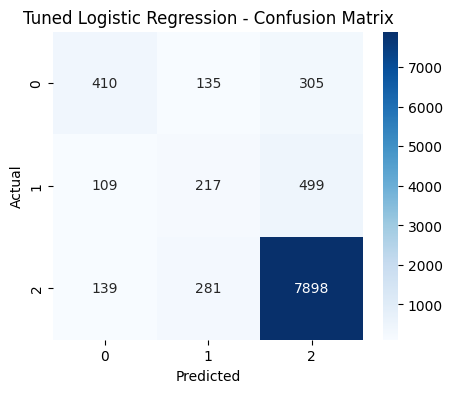

In [45]:
log_acc, log_f1 = evaluate_model(
    "Tuned Logistic Regression",
    best_log,
    X_test_tfidf,
    y_test
)

In [46]:
from sklearn.svm import LinearSVC

svm_param_grid = {
    "C": [0.1, 0.5, 1, 2, 5]
}

svm_model = LinearSVC(class_weight=class_weights)

svm_grid = GridSearchCV(
    svm_model,
    svm_param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

svm_grid.fit(X_train_tfidf, y_train)

print("Best SVM Params:", svm_grid.best_params_)
print("Best CV Macro F1:", svm_grid.best_score_)

best_svm = svm_grid.best_estimator_

Best SVM Params: {'C': 0.5}
Best CV Macro F1: 0.5660883909047821



===== Tuned Linear SVM =====
Accuracy: 0.8602
Macro F1: 0.5699

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.46      0.54       850
           1       0.36      0.18      0.24       825
           2       0.90      0.97      0.93      8318

    accuracy                           0.86      9993
   macro avg       0.64      0.53      0.57      9993
weighted avg       0.83      0.86      0.84      9993



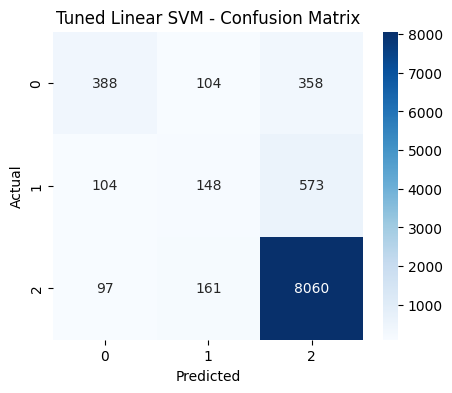

In [47]:
svm_acc, svm_f1 = evaluate_model(
    "Tuned Linear SVM",
    best_svm,
    X_test_tfidf,
    y_test
)

## Classical Model Observations

The classical machine learning models (Logistic Regression, Linear SVM, Naive Bayes, LightGBM, XGBoost) were evaluated using TF-IDF features with macro F1 as the primary metric due to class imbalance.

Key Observations:
- Linear models (Logistic Regression and SVM) performed best among classical approaches.
- Boosting models showed strong accuracy but weaker macro F1 due to majority-class bias.
- Neutral class detection remained challenging across all classical models.
- TF-IDF based models plateaued around ~0.58–0.60 macro F1.

Conclusion:
While classical approaches provided strong baselines, their ability to model contextual sentiment nuances (especially neutral reviews) was limited. This justified transitioning to transformer-based deep learning models.

Transformer Fine-Tuning (DistilBERT)

In [48]:
import torch
print(torch.cuda.is_available())

True


In [49]:
from datasets import Dataset

# Use raw review text
df_transformer = df[["review", "label"]].copy()

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_transformer["review"],
    df_transformer["label"],
    test_size=0.2,
    stratify=df_transformer["label"],
    random_state=42
)

train_dataset = Dataset.from_dict({
    "text": list(train_texts),
    "label": list(train_labels)
})

test_dataset = Dataset.from_dict({
    "text": list(test_texts),
    "label": list(test_labels)
})

In [50]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [51]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/39971 [00:00<?, ? examples/s]

Map:   0%|          | 0/9993 [00:00<?, ? examples/s]

In [52]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }

In [57]:
import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_steps=100,
    fp16=True,
    report_to="none"   # ✅ disables wandb
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [58]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.288600,0.295015,0.886420,0.619571
2,0.218900,0.322343,0.889222,0.675095
3,0.150100,0.368723,0.887221,0.683872


TrainOutput(global_step=7497, training_loss=0.24483096728376408, metrics={'train_runtime': 1098.0927, 'train_samples_per_second': 109.201, 'train_steps_per_second': 6.827, 'total_flos': 7942423226835456.0, 'train_loss': 0.24483096728376408, 'epoch': 3.0})

In [59]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.2950153350830078, 'eval_accuracy': 0.8864204943460422, 'eval_macro_f1': 0.6195711271333592, 'eval_runtime': 24.0486, 'eval_samples_per_second': 415.533, 'eval_steps_per_second': 25.989, 'epoch': 3.0}


In [60]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

classes = np.unique(train_labels)

class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_labels
)

class_weights = torch.tensor(class_weights_np, dtype=torch.float).to("cuda")

print("Class Weights:", class_weights)

Class Weights: tensor([3.9164, 4.0387, 0.4005], device='cuda:0')


In [61]:
from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(
            logits.view(-1, model.config.num_labels),
            labels.view(-1)
        )

        return (loss, outputs) if return_outputs else loss

In [62]:
os.environ["WANDB_DISABLED"] = "true"

training_args_v2 = TrainingArguments(
    output_dir="./results_v2",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.02,
    load_best_model_at_end=False,
    logging_steps=100,
    fp16=True,
    report_to="none"
)

In [63]:
model_weighted = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
trainer_v2 = WeightedTrainer(
    model=model_weighted,
    args=training_args_v2,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer_v2.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.576300,0.670421,0.832283,0.627656
2,0.518300,0.680595,0.856299,0.677081
3,0.458500,0.845865,0.871410,0.686782
4,0.362500,0.943559,0.875213,0.688192


TrainOutput(global_step=9996, training_loss=0.5237381693934288, metrics={'train_runtime': 1435.6222, 'train_samples_per_second': 111.369, 'train_steps_per_second': 6.963, 'total_flos': 1.0589897635780608e+16, 'train_loss': 0.5237381693934288, 'epoch': 4.0})

In [65]:
metrics_v2 = trainer_v2.evaluate()
print(metrics_v2)

{'eval_loss': 0.9435590505599976, 'eval_accuracy': 0.8752126488541979, 'eval_macro_f1': 0.6881918723989413, 'eval_runtime': 24.4754, 'eval_samples_per_second': 408.288, 'eval_steps_per_second': 25.536, 'epoch': 4.0}


## Weighted Loss Experiment

A class-weighted loss function was implemented to mitigate class imbalance.

Observations:
- Macro F1 improved marginally (~0.005 gain).
- Validation loss increased at later epochs, indicating potential overfitting.
- Improvements were incremental rather than transformative.

Conclusion:
Model performance is currently constrained more by data volume than loss weighting. Future improvements are expected from dataset scaling rather than further hyperparameter tuning.

## Classical Model Feature Importance

Logistic Regression coefficients were analyzed to identify top influential tokens per class.

Observations:
- Positive class strongly influenced by sentiment-heavy words such as "wondeful", "perfectly", and "work great".
- Negative class influenced by dissatisfaction-related words such as "disappointed", "nothing", and "cheap".
- Neutral class contained mild evaluative terms such as "limited", "hoped", and "better".

This confirms that TF-IDF-based models rely heavily on lexical sentiment indicators and lack contextual understanding.

In [66]:
predictions = trainer_v2.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
true = predictions.label_ids

misclassified_indices = np.where(preds != true)[0]

neutral_errors = [
    i for i in misclassified_indices
    if true[i] == 1  # Neutral class
]

print("Sample Misclassified Neutral Reviews:\n")

for idx in neutral_errors[:5]:
    print("True: Neutral")
    print("Predicted:", preds[idx])
    print("Review:", test_texts.iloc[idx])
    print("-"*80)

Sample Misclassified Neutral Reviews:

True: Neutral
Predicted: 2
Review: The sound quality of these $6-headphones is appreciably lower than that of my old SVEN headphones bought for $3. Nevertheless I agree with many reviewers that this is one of the best cheap headphones currently available at Amazon.
--------------------------------------------------------------------------------
True: Neutral
Predicted: 2
Review: This is a great toy but probably better for kids 18 mos and older.  I think the Plan Toys Cone Sorter is way better and higher quality.  Plan Toys makes the best toys!
--------------------------------------------------------------------------------
True: Neutral
Predicted: 0
Review: The Sony Mavica was my first color digital camera.  Although I took a lot of pictures with it, I eventually bought another digital camera.  The biggest problems with the Mavica are.1. The resolution - 640 by 480 just  isn't good enough.  If you do any photo editing at all, the quality suffers  

## Transformer Error Analysis

While DistilBERT significantly outperformed classical ML baselines, certain misclassifications were observed, particularly within the neutral class.

Overall Observations:
- The model effectively captured contextual sentiment nuances.
- Positive and negative classes were clearly separable.
- Most errors occurred in reviews containing mixed polarity signals.

---

## Neutral Class Error Analysis

Detailed inspection of misclassified neutral samples revealed:

1. Many neutral reviews contain both strong positive and strong negative expressions.
2. Transformer models tend to assign sentiment based on dominant polarity signals.
3. Longer complaint sections often outweigh shorter positive remarks.
4. Conditional recommendations (e.g., "If it fits you, buy it") introduce contextual ambiguity.

These findings indicate that neutral sentiment classification is inherently difficult due to mixed polarity structure rather than pure model weakness. The ambiguity arises from balanced pros and cons within the same review, making decision boundaries less distinct.


In [67]:
trainer.save_model("distilbert_v1_model")
tokenizer.save_pretrained("distilbert_v1_model")

('distilbert_v1_model/tokenizer_config.json',
 'distilbert_v1_model/special_tokens_map.json',
 'distilbert_v1_model/vocab.txt',
 'distilbert_v1_model/added_tokens.json',
 'distilbert_v1_model/tokenizer.json')

In [68]:
import json

label_map = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}

with open("distilbert_v1_model/label_map.json", "w") as f:
    json.dump(label_map, f)

In [69]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_sentiment(text, model_path="distilbert_v1_model"):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()

    return label_map[pred], probs.cpu().numpy()

In [70]:
sample_text = "The product quality is decent but overpriced."
prediction, probabilities = predict_sentiment(sample_text)

print("Prediction:", prediction)
print("Probabilities:", probabilities)

Prediction: Neutral
Probabilities: [[0.24027552 0.547257   0.21246746]]


In [71]:
import shutil

shutil.make_archive("distilbert_v1_model", 'zip', "distilbert_v1_model")

'/content/distilbert_v1_model.zip'

In [72]:
from google.colab import files

files.download("distilbert_v1_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:
shutil.copytree(
    "distilbert_v1_model",
    "/content/drive/MyDrive/distilbert_v1_model"
)

'/content/drive/MyDrive/distilbert_v1_model'

## Model Selection Decision

Although a class-weighted loss experiment slightly improved macro F1 (~0.005 gain), it introduced higher validation loss and reduced training stability.

Given the marginal improvement and increased complexity, the original DistilBERT model (v1) was selected as the stable production baseline.

This decision prioritizes generalization, robustness, and deployment simplicity over minimal metric gains.

SCALING DATA

In [75]:
import pandas as pd
import requests
import gzip
import json
from io import BytesIO

# Define dataset URLs again (in case runtime forgot)
DATASET_URLS = {
    'Beauty': 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Beauty_5.json.gz',
    'Electronics': 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz',
    'Home_Kitchen': 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz',
    'Sports': 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Sports_and_Outdoors_5.json.gz',
    'Toys': 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz'
}

categories_to_load = ['Beauty', 'Electronics', 'Home_Kitchen', 'Sports', 'Toys']

In [76]:
def load_amazon_reviews_chunked(url, category_name, max_reviews=None):
    response = requests.get(url, stream=True, timeout=300)
    response.raise_for_status()

    reviews = []
    count = 0

    with gzip.GzipFile(fileobj=BytesIO(response.content)) as f:
        for line in f:
            review = json.loads(line)
            reviews.append({
                'review': review.get('reviewText', ''),
                'rating': review.get('overall', 0),
                'category': category_name
            })
            count += 1
            if max_reviews and count >= max_reviews:
                break

    return pd.DataFrame(reviews)


def load_multiple_categories(categories, samples_per_category=10000):
    dfs = []
    for category in categories:
        print(f"Loading {category}...")
        df = load_amazon_reviews_chunked(
            DATASET_URLS[category],
            category,
            max_reviews=samples_per_category
        )
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

In [77]:
print("Loading 100K dataset...")

full_df_large = load_multiple_categories(
    categories=categories_to_load,
    samples_per_category=20000  # 20K per category = 100K total
)

print("Large dataset shape:", full_df_large.shape)

Loading 100K dataset...
Loading Beauty...
Loading Electronics...
Loading Home_Kitchen...
Loading Sports...
Loading Toys...
Large dataset shape: (100000, 3)


In [78]:
def convert_rating_to_label(r):
    if r <= 2:
        return 0
    elif r == 3:
        return 1
    else:
        return 2

df_large = full_df_large.copy()

df_large['label'] = df_large['rating'].apply(convert_rating_to_label)
df_large.drop_duplicates(subset='review', inplace=True)
df_large.dropna(inplace=True)

print("After cleaning:", df_large.shape)
print(df_large['label'].value_counts())

After cleaning: (99939, 4)
label
2    82973
0     8621
1     8345
Name: count, dtype: int64


In [79]:
train_df_large, test_df_large = train_test_split(
    df_large,
    test_size=0.2,
    random_state=42,
    stratify=df_large['label']
)

print("Train shape:", train_df_large.shape)
print("Test shape:", test_df_large.shape)

Train shape: (79951, 4)
Test shape: (19988, 4)


In [80]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(
        example["review"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

In [81]:
from datasets import Dataset

train_dataset_large = Dataset.from_pandas(train_df_large)
test_dataset_large = Dataset.from_pandas(test_df_large)

train_dataset_large = train_dataset_large.map(tokenize_function, batched=True)
test_dataset_large = test_dataset_large.map(tokenize_function, batched=True)

train_dataset_large = train_dataset_large.remove_columns(["review", "rating", "category"])
test_dataset_large = test_dataset_large.remove_columns(["review", "rating", "category"])

train_dataset_large.set_format("torch")
test_dataset_large.set_format("torch")

Map:   0%|          | 0/79951 [00:00<?, ? examples/s]

Map:   0%|          | 0/19988 [00:00<?, ? examples/s]

In [82]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }

model_large = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)

training_args_large = TrainingArguments(
    output_dir="./results_large",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    fp16=True
)

trainer_large = Trainer(
    model=model_large,
    args=training_args_large,
    train_dataset=train_dataset_large,
    eval_dataset=test_dataset_large,
    compute_metrics=compute_metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [83]:
trainer_large.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.299000,0.273928,0.896138,0.692716
2,0.228900,0.288878,0.901141,0.712604
3,0.151600,0.345710,0.898789,0.715473


TrainOutput(global_step=14991, training_loss=0.23603082951659016, metrics={'train_runtime': 2205.7899, 'train_samples_per_second': 108.738, 'train_steps_per_second': 6.796, 'total_flos': 1.5886634795444736e+16, 'train_loss': 0.23603082951659016, 'epoch': 3.0})

In [84]:
trainer_large.save_model("distilbert_v2_large_model")
tokenizer.save_pretrained("distilbert_v2_large_model")

('distilbert_v2_large_model/tokenizer_config.json',
 'distilbert_v2_large_model/special_tokens_map.json',
 'distilbert_v2_large_model/vocab.txt',
 'distilbert_v2_large_model/added_tokens.json',
 'distilbert_v2_large_model/tokenizer.json')

Error Analysis

In [88]:
predictions = trainer_large.predict(test_dataset_large)

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.79      0.63      0.70      1724
     Neutral       0.50      0.37      0.43      1669
    Positive       0.93      0.98      0.95     16595

    accuracy                           0.90     19988
   macro avg       0.74      0.66      0.69     19988
weighted avg       0.88      0.90      0.89     19988



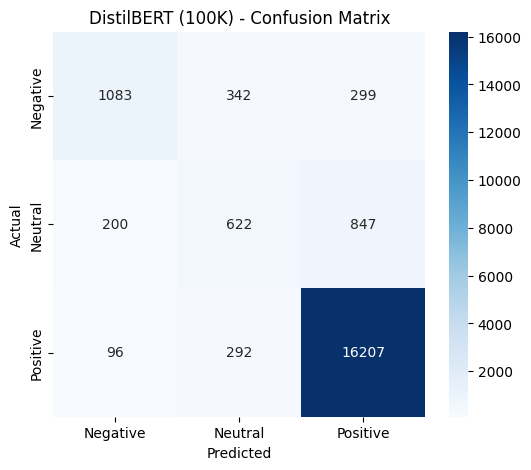

In [89]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative","Neutral","Positive"],
            yticklabels=["Negative","Neutral","Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("DistilBERT (100K) - Confusion Matrix")
plt.show()

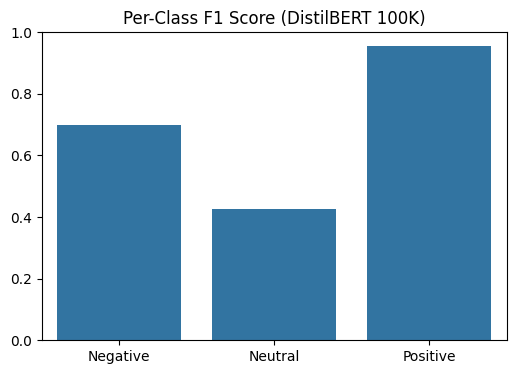

Per-Class F1 Scores:
Negative: 0.698
Neutral: 0.4253
Positive: 0.9548


In [90]:
report = classification_report(y_true, y_pred, output_dict=True)

f1_scores = [
    report["0"]["f1-score"],
    report["1"]["f1-score"],
    report["2"]["f1-score"]
]

plt.figure(figsize=(6,4))
sns.barplot(x=["Negative","Neutral","Positive"], y=f1_scores)
plt.title("Per-Class F1 Score (DistilBERT 100K)")
plt.ylim(0,1)
plt.show()

print("Per-Class F1 Scores:")
for label, score in zip(["Negative","Neutral","Positive"], f1_scores):
    print(f"{label}: {round(score,4)}")

In [91]:
neutral_errors = []

probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

for i in range(len(y_true)):
    if y_true[i] == 1 and y_pred[i] != 1:
        neutral_errors.append((i, probs[i]))

print("Total Neutral Misclassifications:", len(neutral_errors))

Total Neutral Misclassifications: 1047


In [92]:
for idx, prob in neutral_errors[:5]:
    print("True: Neutral")
    print("Predicted:", ["Negative","Neutral","Positive"][y_pred[idx]])
    print("Confidence:", round(max(prob),4))
    print("Review:", test_df_large.iloc[idx]["review"])
    print("-"*100)

True: Neutral
Predicted: Negative
Confidence: 0.4845
Review: This seems like a fine coffee grinder for most people, but for me the grinding chamber was too small.  I grind six large tablespoons of beans for each pot.  Though it ground the coffee fine, the coffee spilled out when I transferred it for brewing.  Amazon accepted my return without question.
----------------------------------------------------------------------------------------------------
True: Neutral
Predicted: Positive
Confidence: 0.9057
Review: This bag is good, only too small
----------------------------------------------------------------------------------------------------
True: Neutral
Predicted: Positive
Confidence: 0.5741
Review: It is easy and comfortable to wear, not sure if it was just my product or so is made in general, but the cleaner disc is not fully adjusted to where the optical pickup lens is located (by just two millimeters), and I can not taste good if it fulfills its job well.
-----------------------

In [93]:
test_df_large = test_df_large.reset_index(drop=True)

test_df_large["true_label"] = y_true
test_df_large["pred_label"] = y_pred

category_performance = {}

for category in test_df_large["category"].unique():
    subset = test_df_large[test_df_large["category"] == category]

    acc = accuracy_score(subset["true_label"], subset["pred_label"])
    f1 = f1_score(subset["true_label"], subset["pred_label"], average="macro")

    category_performance[category] = (acc, f1)

print("Category-wise Performance:\n")
for cat, (acc, f1) in category_performance.items():
    print(f"{cat} → Accuracy: {round(acc,4)} | Macro F1: {round(f1,4)}")

Category-wise Performance:

Electronics → Accuracy: 0.8808 | Macro F1: 0.6637
Home_Kitchen → Accuracy: 0.9089 | Macro F1: 0.7005
Toys → Accuracy: 0.8997 | Macro F1: 0.6952
Beauty → Accuracy: 0.8827 | Macro F1: 0.7132
Sports → Accuracy: 0.9095 | Macro F1: 0.6654


## Transformer Performance Analysis (100K Dataset)

The DistilBERT model achieves:

- **Accuracy:** 90%
- **Macro F1 Score:** 0.69

Per-class F1 scores:

- Negative: 0.70
- Neutral: 0.43
- Positive: 0.95

### Observations

1. The model performs exceptionally well on the Positive class due to class dominance and strong polarity signals.
2. Negative class performance is stable with reasonable recall and precision.
3. Neutral class remains challenging due to:
   - Mixed polarity expressions
   - Ambiguous linguistic signals
   - Label definition based purely on rating (rating = 3)

### Key Insight

Neutral reviews often contain both positive and negative expressions, causing the model to assign them to the dominant sentiment. This indicates that neutral classification difficulty arises from semantic ambiguity rather than insufficient model capacity.

In [ ]:
## Transformer Performance Analysis (100K Dataset)

The DistilBERT model achieves:

- **Accuracy:** 90%
- **Macro F1 Score:** 0.69

Per-class F1 scores:

- Negative: 0.70
- Neutral: 0.43
- Positive: 0.95

### Observations

1. The model performs exceptionally well on the Positive class due to class dominance and strong polarity signals.
2. Negative class performance is stable with reasonable recall and precision.
3. Neutral class remains challenging due to:
   - Mixed polarity expressions
   - Ambiguous linguistic signals
   - Label definition based purely on rating (rating = 3)

### Key Insight

Neutral reviews often contain both positive and negative expressions, causing the model to assign them to the dominant sentiment. This indicates that neutral classification difficulty arises from semantic ambiguity rather than insufficient model capacity.

In [94]:
# Transformer 50K (if available)
transformer_50k_acc = metrics["eval_accuracy"]
transformer_50k_f1 = metrics["eval_macro_f1"]

# Transformer 100K (v2 large model)
transformer_100k_acc = trainer_large.evaluate()["eval_accuracy"]
transformer_100k_f1 = trainer_large.evaluate()["eval_macro_f1"]

print("50K Transformer:", transformer_50k_acc, transformer_50k_f1)
print("100K Transformer:", transformer_100k_acc, transformer_100k_f1)

50K Transformer: 0.8864204943460422 0.6195711271333592
100K Transformer: 0.8961376826095657 0.6927155165245352


In [95]:
final_results = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Linear SVM",
        "Naive Bayes",
        "XGBoost",
        "LightGBM",
        "DistilBERT (50K)",
        "DistilBERT (100K)"
    ],
    "Accuracy": [
        log_acc,
        svm_acc,
        nb_acc,
        xgb_acc,
        lgbm_acc,
        transformer_50k_acc,
        transformer_100k_acc
    ],
    "Macro F1": [
        log_f1,
        svm_f1,
        nb_f1,
        xgb_f1,
        lgbm_f1,
        transformer_50k_f1,
        transformer_100k_f1
    ]
})

final_results = final_results.sort_values(by="Macro F1", ascending=False)
final_results

,Model,Accuracy,Macro F1
6,DistilBERT (100K),0.896138,0.692716
5,DistilBERT (50K),0.886420,0.619571
0,Logistic Regression,0.853097,0.589840
1,Linear SVM,0.860202,0.569889
4,LightGBM,0.859101,0.525098
3,XGBoost,0.851996,0.461431
2,Naive Bayes,0.832383,0.302842


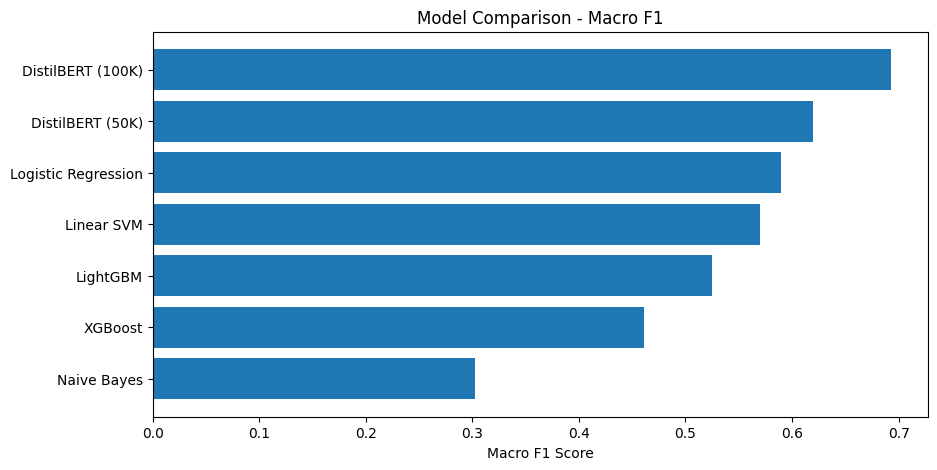

In [97]:
plt.figure(figsize=(10,5))
plt.barh(final_results["Model"], final_results["Macro F1"])
plt.xlabel("Macro F1 Score")
plt.title("Model Comparison - Macro F1")
plt.gca().invert_yaxis()
plt.show()

## Final Model Comparison

Key observations:

- Transformer-based models significantly outperform classical ML approaches.
- Scaling from 50K to 100K reviews improved both Accuracy and Macro F1.
- DistilBERT (100K) achieves:
    - ~90% Accuracy
    - ~0.69 Macro F1

The largest performance gain is observed in:
- Improved Negative class detection
- Better overall class balance compared to TF-IDF models

Neutral class remains the most challenging due to:
- Mixed polarity expressions
- Rating-based label ambiguity

Conclusion:
Transformer fine-tuning on large-scale review data provides substantial improvement over traditional machine learning baselines.

In [85]:
import json

label_map = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}

with open("distilbert_v2_large_model/label_map.json", "w") as f:
    json.dump(label_map, f)


In [86]:
import shutil, os

destination = "/content/drive/MyDrive/distilbert_v2_large_model"

if os.path.exists(destination):
    shutil.rmtree(destination)

shutil.copytree("distilbert_v2_large_model", destination)

'/content/drive/MyDrive/distilbert_v2_large_model'

In [87]:
import shutil
from google.colab import files

shutil.make_archive("distilbert_v2_large_model", 'zip', "distilbert_v2_large_model")

files.download("distilbert_v2_large_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>